In [367]:
import os
import re
from math import sqrt
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely import wkt
from pysal.lib import weights
from pysal.explore import esda
import matplotlib.pyplot as plt
import seaborn as sns
import contextily
from spreg import OLS_Regimes
from pysal.model import spreg
import statsmodels.formula.api as smf
import contextily as ctx
from libpysal.weights import KNN
from spreg import OLS
from libpysal.weights import lag_spatial
from spreg import GM_Lag
from libpysal.weights import Kernel
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Spacial Regression

--> Embed location through the model

## Load data

In [415]:
well_filter = 1

current_dir = os.getcwd()
path = os.path.join(current_dir, '../../data/clean/aligned_data', f"merged_dataset_{well_filter}.csv")
df = pd.read_csv(path)
len(df)

192

In [416]:
df = df[df["soil region"] != "veen"]
len(df)

175

In [419]:
df = df.drop(columns='groundwater depth')

In [420]:
df

,bro-id,nitrate,geometry,date,soil region,landuse code,population,elevation,lon,lat,precipitation,temperature,n deposition,mainsoilclassification_1,organicmattercontent_1,density_1,acidity_1,year_month
0,GAR000000000784,29.370,POINT (5.600793941 51.962453539),2012-02-23 10:00:00+00:00,zand,11.0,40.0,12.048532,5.600794,51.962454,8.75,29.466667,27.383685,Dikke eerdgronden,2.0,1.425,4.5,2012-02
1,GAR000000000775,0.050,POINT (5.601761312 51.976104861),2012-02-23 10:00:00+00:00,zand,1.0,30.0,7.951430,5.601761,51.976105,8.75,29.466667,24.876432,Moerige gronden,25.0,0.597,4.8,2012-02
2,GAR000000001018,0.050,POINT (5.209280883 52.082304626),2012-02-28 10:00:00+00:00,klei,18.0,345.0,4.805576,5.209281,52.082305,1.00,28.900000,22.859424,NaN,NaN,NaN,NaN,2012-02
3,GAR000000001134,3.740,POINT (5.206717551 52.113087483),2012-02-28 10:00:00+00:00,zand,12.0,0.0,4.656710,5.206718,52.113087,1.00,28.900000,26.599293,Kalkloze zandgronden,3.0,1.473,3.4,2012-02
4,GAR000000001080,0.050,POINT (5.187673269 52.052827185),2012-02-28 10:00:00+00:00,klei,1.0,15.0,4.336389,5.187673,52.052827,1.00,28.900000,28.378182,Rivierkleigronden,4.0,1.220,5.5,2012-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170,GAR000000034889,0.029,POINT (5.37357013 52.160911559),2020-05-12 11:00:00+00:00,zand,28.0,755.0,7.023899,5.373570,52.160912,1.50,97.666667,35.143563,NaN,NaN,NaN,NaN,2020-05
171,GAR000000040754,0.029,POINT (5.553090732 52.015559849),2020-07-23 11:00:00+00:00,zand,23.0,1580.0,8.000000,5.553091,52.015560,0.00,168.700000,31.683834,NaN,NaN,NaN,NaN,2020-07
172,GAR000000040631,0.029,POINT (5.535157514 52.05581825),2020-07-23 11:00:00+00:00,zand,25.0,0.0,7.000000,5.535158,52.055818,0.00,168.700000,18.335163,Kalkloze zandgronden,5.5,1.373,4.8,2020-07
173,GAR000000034978,6.645,POINT (5.220059643 52.135058137),2020-07-27 11:00:00+00:00,zand,23.0,925.0,7.272202,5.220060,52.135058,16.50,170.750000,22.803396,NaN,NaN,NaN,NaN,2020-07


## Sort by date

In [421]:
# sort by date
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values("date").reset_index(drop=True)

In [422]:
df['year_month'] = df['date'].dt.to_period('M')  # year + month (e.g., 2012-03)

# Count number of data points per year-month
counts = df['year_month'].value_counts().sort_index()
print(counts)

year_month
2012-02     7
2012-03    23
2012-04     4
2012-06     7
2012-10     2
2013-10     8
2014-09     6
2015-06    37
2015-07     1
2015-08     1
2015-09     1
2016-09     6
2017-08     2
2017-12     6
2018-05    40
2018-06     4
2018-08     6
2019-07     8
2020-05     2
2020-07     4
Freq: M, Name: count, dtype: int64


/var/folders/fr/h0n611t55y51b_mts5q50l540000gn/T/ipykernel_6389/2666782288.py:1: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['year_month'] = df['date'].dt.to_period('M')  # year + month (e.g., 2012-03)


## Remove outlier based on "Soil region"

In [423]:
print(df["soil region"].value_counts())

soil region
zand    132
klei     43
Name: count, dtype: int64


## Add month and year as features

In [424]:
# df["month"] = df["date"].dt.month
df["year"] = df["date"].dt.year

## Log transform

In [425]:
df["nitrate"] = np.log1p(df["nitrate"])

## Remove columns

In [426]:
df = df.drop(columns=["date", 'bro-id', 'lon', 'lat'])
print(df.columns)
len(df)

Index(['nitrate', 'geometry', 'soil region', 'landuse code', 'population',
       'elevation', 'precipitation', 'temperature', 'n deposition',
       'mainsoilclassification_1', 'organicmattercontent_1', 'density_1',
       'acidity_1', 'year_month', 'year'],
      dtype='object')


175

## Change column type

In [427]:
# convert to categorical
predefined_categories = {
    "soil region": None,
    "landuse code": None,
    "mainsoilclassification_1": None 
}


for col, fixed_categories in predefined_categories.items():
    if col in df.columns:
        categories = sorted(df[col].dropna().unique().tolist())
        
        df[col] = pd.Categorical(df[col], categories=categories)

In [428]:
df.dtypes

nitrate                       float64
geometry                       object
soil region                  category
landuse code                 category
population                    float64
elevation                     float64
precipitation                 float64
temperature                   float64
n deposition                  float64
mainsoilclassification_1     category
organicmattercontent_1        float64
density_1                     float64
acidity_1                     float64
year_month                  period[M]
year                            int32
dtype: object

## Remove spatial outlier

In [162]:
# GMW000000024093

# target_well = ['GAR000000000307', 'GAR000000000308', 'GAR000000000309']
# df = df.drop(df[df["bro-id"].isin(target_well)].index)
# len(df)

129

## Preprocess (alternative)

In [429]:
def split_and_preprocess(df, cols_to_drop, holdout_cols = None):
    if holdout_cols is None:
        holdout_cols = []

    df = df.drop(columns=cols_to_drop)
    df = df.dropna()
    len(df)

    train_df = df[df["year"].isin([2012, 2013, 2014, 2015, 2016, 2017])]
    test_df  = df[df["year"].isin([2018, 2019, 2020])]

    print(f"Train: {len(train_df)}")
    print(f"Test: {len(test_df)}")

    holdout_train = train_df[holdout_cols].copy()
    holdout_test = test_df[holdout_cols].copy()

    X_train_raw = train_df.drop(columns=["nitrate", "year"] + holdout_cols).copy()
    y_train = train_df["nitrate"].values.reshape(-1, 1)

    X_test_raw = test_df.drop(columns=["nitrate", "year"] + holdout_cols).copy()
    y_test = test_df["nitrate"].values.reshape(-1, 1)

    categorical_cols = X_train_raw.select_dtypes(include="category").columns.tolist()
    numerical_cols = X_train_raw.select_dtypes(include=["float64", "int64"]).columns.tolist()

    # construct a transformer
    transformers = []

    if categorical_cols:
        transformers.append(
            ("cat_ohe", OneHotEncoder(handle_unknown="ignore", drop='first', sparse_output=False), categorical_cols)
        )

    if numerical_cols:
        transformers.append(
            ("num_scaler", StandardScaler(), numerical_cols)
        )

    preprocessor = ColumnTransformer(transformers)

    X_train = preprocessor.fit_transform(X_train_raw)
    X_test = preprocessor.transform(X_test_raw)

    # extract feature names
    if categorical_cols:
        cat_ohe = preprocessor.named_transformers_["cat_ohe"]
        ohe_feature_names = cat_ohe.get_feature_names_out(categorical_cols).tolist()
    else:
        ohe_feature_names = []

    if numerical_cols:
        num_feature_names = numerical_cols.copy()
    else:
        numerical_cols = []
    
    feature_names = ohe_feature_names + num_feature_names

    # convert back to pd Dataframe
    X_train = pd.DataFrame(X_train, columns=feature_names, index=X_train_raw.index)
    X_test = pd.DataFrame(X_test, columns=feature_names, index=X_test_raw.index)
    y_train = pd.DataFrame(y_train, columns=["nitrate"], index=X_train_raw.index)
    y_test = pd.DataFrame(y_test, columns=["nitrate"], index=X_test_raw.index)

    X_train = pd.concat([X_train, holdout_train], axis=1)
    X_test = pd.concat([X_test, holdout_test], axis=1)

    return X_train, y_train, X_test, y_test, feature_names

## Simple OLS regression

In [430]:
cols_to_drop_1 = ['landuse code', 'soil region', 'mainsoilclassification_1']
X_train, y_train, X_test, y_test, feature_names = split_and_preprocess(df, cols_to_drop_1)

Train: 75
Test: 44


In [431]:
ols_model = spreg.OLS(y_train, X_train, name_y='nitrate', name_x=feature_names)
print(ols_model.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :     nitrate                Number of Observations:          75
Mean dependent var  :      1.0505                Number of Variables   :           9
S.D. dependent var  :      1.0312                Degrees of Freedom    :          66
R-squared           :      0.4655
Adjusted R-squared  :      0.4007
Sum squared residual:     42.0597                F-statistic           :      7.1854
Sigma-square        :       0.637                Prob(F-statistic)     :   8.394e-07
S.E. of regression  :       0.798                Log likelihood        :     -84.730
Sigma-square ML     :       0.561                Akaike info criterion :     187.461
S.E of regression ML:      0.7489                Schwarz criterion     :     208.318

------------------------------------------------------------

In [432]:
beta = ols_model.betas.flatten()

X_test_with_const = np.hstack([np.ones((X_test.shape[0], 1)), X_test])

y_pred = X_test_with_const @ beta

print("Test R2:", r2_score(np.expm1(y_test),  np.expm1(y_pred)))
print("Test MAE:",mean_absolute_error(y_test, y_pred))
print("Test RMSE:", sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred))))

Test R2: 0.0384781608509388
Test MAE: 0.6406284818719192
Test RMSE: 3.9974482996920893


## Spatial fixed effects

--> We influence constant term

--> Instead of assuming the dependent variable behaves uniformly over space, there are systematic effects following a geographical pattern

--> Constant term to vary geographically

--> **Other** elements of the regression are left untouched and hence apply **uniformly** across space

--> Each region gets its own intercept

--> Control for spatial heterogeneity

In [433]:
cols_to_drop_2 = ['landuse code', 'mainsoilclassification_1']
holdout_cols = ["soil region"]

X_train, y_train, X_test, y_test, feature_names = split_and_preprocess(df, cols_to_drop_2, holdout_cols)

Train: 75
Test: 44


In [434]:
train_df_for_formula = X_train.copy()
train_df_for_formula['nitrate'] = y_train

test_df_for_formula = X_test.copy()
test_df_for_formula['nitrate'] = y_test

In [437]:
# variable_names = ['population',
# 'groundwater depth',
# 'elevation',
# 'precipitation',
# 'temperature',
# 'n deposition',
# 'organicmattercontent_1',
# 'density_1',
# 'acidity_1']

variable_names = ['population',
'elevation',
'precipitation',
'temperature',
'n deposition',
'organicmattercontent_1',
'density_1',
'acidity_1']


formula = "nitrate ~ " + " + ".join([f"Q('{col}')" for col in variable_names]) + " + C(Q('soil region')) - 1"

In [438]:
model_2 = smf.ols(formula, data=train_df_for_formula).fit()

In [439]:
print(model_2.summary())

                            OLS Regression Results                            
Dep. Variable:                nitrate   R-squared:                       0.493
Model:                            OLS   Adj. R-squared:                  0.422
Method:                 Least Squares   F-statistic:                     7.009
Date:                Fri, 06 Jun 2025   Prob (F-statistic):           5.30e-07
Time:                        23:25:20   Log-Likelihood:                -82.787
No. Observations:                  75   AIC:                             185.6
Df Residuals:                      65   BIC:                             208.7
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
C(Q('soil region')

#### Wells on **zand** soils have significantly **higher nitrate** concentrations, even when controlling for depth, population, temperature

--> The log nitrate concentration is, on average, 0.7 units lower in klei (clay) regions

In [440]:
# Step 1: Extract fixed effect names
sfe_names = [i for i in model_2.params.index if "C(Q('soil region'))" in i]

# Step 2: Extract soil region names using regex
soil_region_labels = []
for name in sfe_names:
    match = re.search(r"\[T\.(.*)\]", name)
    if match:
        soil_region_labels.append(match.group(1))
    else:
        # If no match, fallback to raw name (for safety)
        soil_region_labels.append(name)

# Step 3: Create DataFrame
soil_fixed_effects = pd.DataFrame({
    "soil_region": soil_region_labels,
    "Coef.": model_2.params[sfe_names],
    "Std. Error": model_2.bse[sfe_names],
    "P-Value": model_2.pvalues[sfe_names],
})

soil_fixed_effects

,soil_region,Coef.,Std. Error,P-Value
C(Q('soil region'))[klei],C(Q('soil region'))[klei],0.669912,0.223790,3.897172e-03
C(Q('soil region'))[zand],C(Q('soil region'))[zand],1.264547,0.146445,2.183532e-12


In [441]:
y_pred = model_2.predict(test_df_for_formula)

In [442]:
print("Test R2:", r2_score(np.expm1(y_test),  np.expm1(y_pred)))
print("Test MAE:",mean_absolute_error(y_test, y_pred))
print("Test RMSE:", sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred))))

Test R2: 0.12724098719988342
Test MAE: 0.6531557007286486
Test RMSE: 3.8084692231371347


## Spatial Regimes

--> We modify set of coeficients depending on the location

--> Spatial regimes (SRs) is to generalize the spatial FE approach to allow not only the constant term to vary but also any other explanatory variable

--> We want the whole model — intercept and slopes — to vary between geographic groups

In [443]:
cols_to_drop_3 = ['landuse code', 'mainsoilclassification_1']
holdout_cols = ['soil region']

X_train, y_train, X_test, y_test, feature_names = split_and_preprocess(df, cols_to_drop_3, holdout_cols)

Train: 75
Test: 44


In [447]:
# variable_names = ['population',
# 'groundwater depth',
# 'elevation',
# 'precipitation',
# 'temperature',
# 'n deposition',
# 'organicmattercontent_1',
# 'density_1',
# 'acidity_1']

variable_names = ['population',
'elevation',
'precipitation',
'temperature',
'n deposition',
'organicmattercontent_1',
'density_1',
'acidity_1']

In [448]:
m5 = spreg.OLS_Regimes(
    # Dependent variable
    y_train.values,
    # Independent variables
    X_train[variable_names].values,
    # Variable specifying neighborhood membership
    X_train["soil region"].tolist(),
    # Allow the constant term to vary by group/regime
    constant_regi="many",
    # Allow separate sigma coefficients to be estimated
    # by regime (False so a single sigma)
    regime_err_sep=False,
    # Dependent variable name
    name_y="nitrate",
    # Independent variables names
    name_x=variable_names
)

In [449]:
m5 = spreg.OLS_Regimes(
    y=y_train.values,
    x=X_train[variable_names].values,
    regimes=X_train["soil region"].tolist(),
    constant_regi="many",     # varying intercepts
    regime_err_sep=False,     # shared residual variance
    name_y="nitrate",
    name_x=variable_names
)

In [450]:
print(m5.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES - REGIMES
---------------------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :     nitrate                Number of Observations:          75
Mean dependent var  :      1.0505                Number of Variables   :          18
S.D. dependent var  :      1.0312                Degrees of Freedom    :          57
R-squared           :      0.6209
Adjusted R-squared  :      0.5078
Sum squared residual:     29.8327                F-statistic           :      5.4914
Sigma-square        :       0.523                Prob(F-statistic)     :   5.288e-07
S.E. of regression  :       0.723                Log likelihood        :     -71.850
Sigma-square ML     :       0.398                Akaike info criterion :     179.700
S.E of regression ML:      0.6307                Schwarz criterion     :     221.414

----------------------------------------

In [451]:
res = pd.DataFrame({
    "Coeff.": m5.betas.flatten(),
    "Std. Error": m5.std_err.flatten(),
    "P-Value": [i[1] for i in m5.t_stat],
}, index=m5.name_x)

soil_types = df["soil region"].unique()

regime_tables = []
for soil in soil_types:
    matching_rows = [i for i in res.index if i.startswith(f"{soil}_")]
    regime_res = res.loc[matching_rows].rename(lambda i: i.replace(f"{soil}_", ""))
    regime_res.columns = pd.MultiIndex.from_product([[soil], regime_res.columns])
    regime_tables.append(regime_res)

comparison_table = pd.concat(regime_tables, axis=1)

comparison_table

zand                               klei  \
                          Coeff. Std. Error       P-Value    Coeff.   
CONSTANT                1.964134   0.218908  1.712900e-12  1.244748   
population              0.048964   0.100535  6.281031e-01  0.883067   
elevation               0.041664   0.100765  6.808098e-01  0.853849   
precipitation          -0.103358   0.121356  3.979506e-01 -0.043239   
temperature            -0.201126   0.112787  7.987307e-02 -0.087331   
n deposition           -0.210185   0.137491  1.318656e-01 -0.042625   
organicmattercontent_1 -2.742799   0.627385  5.288388e-05  0.052496   
density_1              -2.943543   0.746178  2.212707e-04  0.314750   
acidity_1              -0.560704   0.202411  7.550986e-03 -0.218498   

                                             
                       Std. Error   P-Value  
CONSTANT                 0.371513  0.001436  
population               1.262729  0.487189  
elevation                0.802979  0.292106  
precipitation            0.134006  0.748127  
temperature              0.157756  0.582031  
n deposition             0.416621  0.918868  
organicmattercontent_1   1.011408  0.958787  
density_1                0.411840  0.447869  
acidity_1                0.267705  0.417791

CHOW test check if coefficients for each predictor is statistically different across the groups (klei vs zand)

In [452]:
import numpy as np
from sklearn.metrics import mean_squared_error

# ‣ 1. Flatten the coefficient vector from the fitted model
beta_vec = m5.betas.flatten()  
#    shape = (R*(1 + len(variable_names)),)  

# ‣ 2. Recover the exact “regime order” that PySAL used internally.
#    m5.name_x is a list like ["clay_CONSTANT", "clay_population", …, "sand_CONSTANT", …, …].
regime_order = []
for nm in m5.name_x:
    soil = nm.split("_")[0]
    if soil not in regime_order:
        regime_order.append(soil)
#    Now regime_order = [ "clay", "sand", "peaty", … ] in the precise sequence PySAL stacked them.

R = len(regime_order)
K = len(variable_names)
n_test = X_test.shape[0]

# ‣ 3. Build the “extended” test‐matrix of size (n_test, R*(1+K)).
#    Column‐block layout: for regime i = 0..R−1,
#      column  i*(K+1)   = intercept_dummy_i  = (soil_region == regime_i ? 1 : 0)
#      columns i*(K+1)+1 ... i*(K+1)+K =  (soil_region == regime_i) *  X_test[var_k]
X_test_ext = np.zeros((n_test, R * (K + 1)))

for i, regime in enumerate(regime_order):
    # Boolean mask of shape (n_test,): 1 if this test‐row belongs to `regime`, else 0
    mask = (X_test["soil region"] == regime).astype(int).values

    # intercept dummy for regime i
    X_test_ext[:, i * (K + 1)] = mask

    # for each covariate k, multiply mask * X_test[var_k]
    for j, var in enumerate(variable_names):
        X_test_ext[:, i * (K + 1) + 1 + j] = mask * X_test[var].values

In [453]:
# ‣ 4. Form y_test as a 1D array of the log1p(nitrate) target
y_test_log = y_test["nitrate"].values.flatten()

# ‣ 5. Compute predicted log1p(nitrate) on the test set
y_pred_log = X_test_ext.dot(beta_vec)

# ‣ 6. Evaluate in log‐space (for example, RMSE in log1p scale)
mse_log = mean_squared_error(y_test_log, y_pred_log)
rmse_log = np.sqrt(mse_log)
print(f"Test RMSE (log1p‐nitrate): {rmse_log:.4f}")

# ‣ 7. If you also want an “original‐scale” error, back‐transform both sides:
y_test_orig = np.expm1(y_test_log)     # invert log1p
y_pred_orig = np.expm1(y_pred_log)

mse_orig = mean_squared_error(y_test_orig, y_pred_orig)
rmse_orig = np.sqrt(mse_orig)
print(f"Test RMSE (original‐nitrate): {rmse_orig:.4f}")

r2_log = r2_score(y_test_log, y_pred_log)
print(f"Test  R² (log1p‐nitrate): {r2_log:.4f}")

# 2) R² on the original‐nitrate scale
r2_orig = r2_score(y_test_orig, y_pred_orig)
print(f"Test  R² (original‐nitrate): {r2_orig:.4f}")

Test RMSE (log1p‐nitrate): 0.6460
Test RMSE (original‐nitrate): 3.2418
Test  R² (log1p‐nitrate): 0.4609
Test  R² (original‐nitrate): 0.3676


In [454]:
m5.chow.joint

(23.361622207762274, 0.005433273236262128)

In [455]:
pd.DataFrame(
    # Chow results by variable
    m5.chow.regi,
    # Name of variables
    index=m5.name_x_r,
    # Column names
    columns=["Statistic", "P-value"],
)

,Statistic,P-value
CONSTANT,2.783201,0.095258
population,0.433585,0.510235
elevation,1.007202,0.315574
precipitation,0.110578,0.739487
temperature,0.344322,0.557345
n deposition,0.145868,0.702516
organicmattercontent_1,5.515959,0.018844
density_1,14.615318,0.000132
acidity_1,1.039673,0.307898


## Spatial dependence

--> Maybe neighbors surrounding the data point influence its value

--> We add spatial context

--> Calculate average of variables in the surrounding locations

--> NOTE: simple knn **worked better** than kernel

In [389]:
cols_to_drop_3 = ['landuse code', 'soil region', 'mainsoilclassification_1']
holdout_cols = ['geometry']

X_train, y_train, X_test, y_test, feature_names = split_and_preprocess(df, cols_to_drop_3, holdout_cols)

Train: 75
Test: 43


In [392]:
X_train["geometry"] = X_train["geometry"].apply(wkt.loads)
X_test["geometry"] = X_test["geometry"].apply(wkt.loads)

In [412]:
X_train

,population,groundwater depth,elevation,precipitation,temperature,n deposition,organicmattercontent_1,density_1,acidity_1,geometry
0,-0.126952,1.398751,0.390583,-0.371595,-1.428436,0.863313,-0.833994,0.515985,-0.013615,POINT (623477.53 6793339.418)
1,-0.172838,1.398751,-0.082300,-0.371595,-1.428436,0.059403,5.591376,-4.523753,0.326769,POINT (623585.217 6795806.059)
3,-0.310497,-0.236669,-0.462574,-0.503739,-1.439240,0.611810,-0.554631,0.808143,-1.261691,POINT (579609.146 6820599.007)
4,-0.241668,-1.201940,-0.499545,-0.503739,-1.439240,1.182183,-0.275267,-0.731776,1.120999,POINT (577489.147 6809682.929)
7,-0.310497,-0.235158,-0.190898,-0.499476,-1.444007,0.957627,-0.554631,0.808143,-1.261691,POINT (586991.235 6827266.865)
...,...,...,...,...,...,...,...,...,...,...
103,-0.264611,0.619039,-0.437379,-0.418485,1.462684,-0.618757,0.004097,-0.263105,1.007538,POINT (590652.901 6797782.79)
104,-0.172838,-1.325907,-0.499545,-0.166985,1.461731,0.149225,-0.275267,-0.731776,1.120999,POINT (577489.147 6809682.929)
106,-0.310497,0.173251,-0.192113,1.631881,-0.344079,-1.040922,0.143779,0.199479,0.326769,POINT (616170.916 6810224.409)
107,-0.149895,-0.327468,-0.090207,0.996736,-0.387706,1.285479,-0.554631,0.808143,-1.261691,POINT (591049.501 6809451.911)


In [393]:
X_train = gpd.GeoDataFrame(X_train, geometry="geometry", crs="EPSG:4326")
X_test = gpd.GeoDataFrame(X_test, geometry="geometry", crs="EPSG:4326")

In [406]:
knn = KNN.from_dataframe(X_train, k=15)

/Users/Administrator/Documents/University/Year 3/2b/Thesis/Bachelor-Thesis/spatial_env/lib/python3.9/site-packages/libpysal/weights/weights.py:224: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


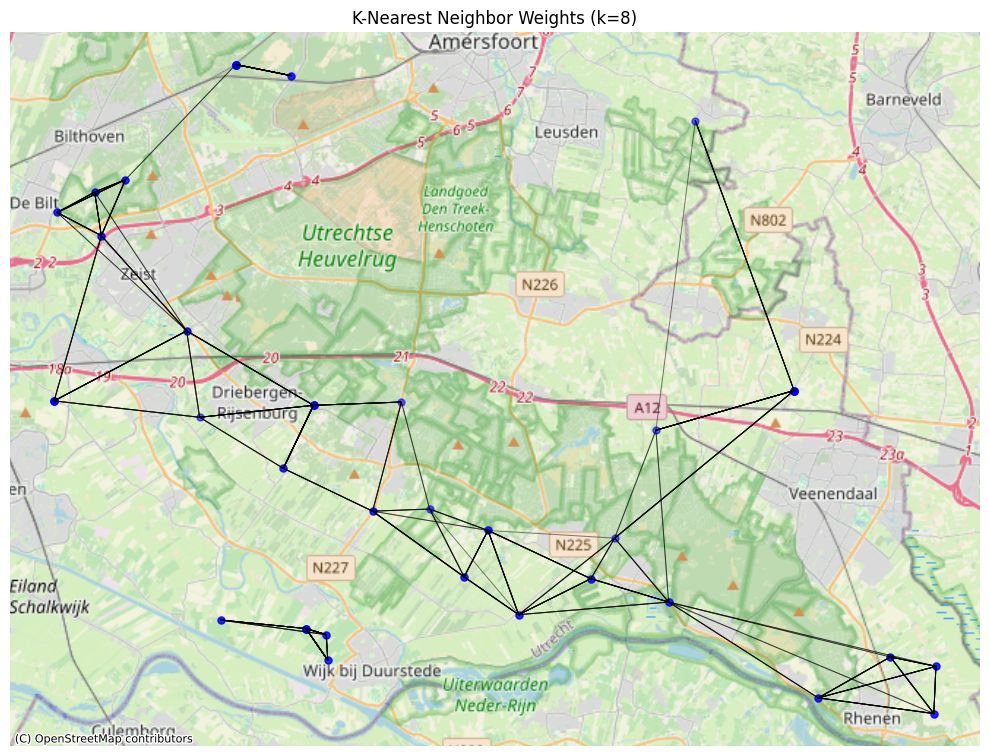

In [413]:
# 1. Use the same GeoDataFrame for both knn and plotting
gdf = X_train.copy()
gdf = gdf.to_crs(epsg=3857).reset_index(drop=True)

# 2. Compute KNN weights on the same gdf
from libpysal.weights import KNN
knn = KNN.from_dataframe(gdf, k=8)

# 3. Plot points
fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(ax=ax, color='blue', alpha=0.6, markersize=25)

# 4. Plot KNN edges
for i, neighbors in knn.neighbors.items():
    origin = gdf.geometry.iloc[i]
    for j in neighbors:
        if j < len(gdf):  # safety check
            dest = gdf.geometry.iloc[j]
            ax.plot(
                [origin.x, dest.x],
                [origin.y, dest.y],
                color='black',
                linewidth=0.7,
                alpha=0.5
            )

# 5. Add basemap
import contextily as ctx
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, crs=gdf.crs)
ax.set_axis_off()
plt.title("K-Nearest Neighbor Weights (k=8)")
plt.tight_layout()
plt.show()


In [ ]:
lagged_vars = ['groundwater depth', 'population', 'temperature', 'precipitation',
       'elevation', 'organicmattercontent_1', 'density_1', 'acidity_1', 'n deposition']

In [ ]:
wx = X_all[lagged_vars].apply(lambda col: lag_spatial(knn, col), axis=0)  #spatial lag to each variable

In [349]:
X_all.columns

Index(['population', 'groundwater depth', 'elevation', 'precipitation',
       'temperature', 'n deposition', 'organicmattercontent_1', 'density_1',
       'acidity_1', 'month', 'soilunit_code_1_Y30', 'soilunit_code_1_pZg21',
       'soilunit_code_1_zEZ21'],
      dtype='object')

In [350]:
lagged_vars = ['groundwater depth', 'population', 'temperature', 'precipitation',
       'elevation', 'organicmattercontent_1', 'density_1', 'acidity_1', 'n deposition']

wx = X_all[lagged_vars].apply(lambda col: lag_spatial(knn, col), axis=0)  #spatial lag to each variable

wx.columns = ["w_" + col for col in wx.columns]# renaming

In [351]:
slx_X = pd.concat([X_all, wx], axis=1)  # combine original and lagged features

In [352]:
y = df["log_nitrate"].values.reshape(-1, 1)

In [353]:
m6 = OLS(
    y=y,
    x=slx_X.values,
    name_y="log_nitrate",
    name_x=slx_X.columns.tolist(),
)

In [354]:
print(m6.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  : log_nitrate                Number of Observations:         118
Mean dependent var  :      0.9689                Number of Variables   :          23
S.D. dependent var  :      0.9850                Degrees of Freedom    :          95
R-squared           :      0.8376
Adjusted R-squared  :      0.8000
Sum squared residual:     18.4392                F-statistic           :     22.2680
Sigma-square        :       0.194                Prob(F-statistic)     :   2.692e-28
S.E. of regression  :       0.441                Log likelihood        :     -57.919
Sigma-square ML     :       0.156                Akaike info criterion :     161.838
S.E of regression ML:      0.3953                Schwarz criterion     :     225.563

------------------------------------------------------------

In [355]:
lagged_names = wx.columns

slx_results = pd.DataFrame({
    "Coeff.": m6.betas.flatten(),
    "Std. Error": m6.std_err.flatten(),
    "P-Value": [t[1] for t in m6.t_stat],
}, index=m6.name_x)

# View just the spatial lag effects (and round for readability)
slx_results.loc[lagged_names].round(4)


,Coeff.,Std. Error,P-Value
w_groundwater depth,0.0333,0.0121,0.0073
w_population,0.0007,0.0005,0.1550
w_temperature,-0.0021,0.0007,0.0031
w_precipitation,0.0017,0.0007,0.0202
w_elevation,-0.0030,0.0033,0.3672
w_organicmattercontent_1,0.0480,0.0171,0.0060
w_density_1,0.6810,0.4354,0.1211
w_acidity_1,0.1516,0.0519,0.0043
w_n deposition,0.0220,0.0098,0.0267


Groundwater depth, Temperature, Precipitaion, Organic content, Acidity, N deposition significantly effect the Nitrate level at specific location

## Spacial Lag

--> How Y variable in neighborhood affects Y variable in other location

--> NOTE: Lagging nitrate from neighbours can be problematic. Nitrate is not sampled at the same time across the area

In [356]:
m8 = GM_Lag(
    y=y,
    x=X,
    w=knn,
    name_y="log_nitrate",
    name_x=list(X_all.columns),
)

In [357]:
print(m8.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: SPATIAL TWO STAGE LEAST SQUARES
--------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  : log_nitrate                Number of Observations:         118
Mean dependent var  :      0.9689                Number of Variables   :          15
S.D. dependent var  :      0.9850                Degrees of Freedom    :         103
Pseudo R-squared    :      0.7504
Spatial Pseudo R-squared:  0.6376

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT         3.81313         1.66734         2.28695         0.02220
          population         0.00028         0.00024         1.17301         0.24079
   groundwater depth         0.15867      

In [2234]:
pd.DataFrame({
    "Coeff.": m8.betas.flatten(),
    "Std. Error": m8.std_err.flatten(),
    "P-Value": [z[1] for z in m8.z_stat],
}, index=m8.name_z).round(4)

,Coeff.,Std. Error,P-Value
CONSTANT,0.2243,0.5076,0.6586
avg_depth_m,0.1167,0.0787,0.1383
Population,0.0004,0.0004,0.2867
avg_temp_mean,-0.0048,0.0050,0.3356
avg_precip_sum,-0.0092,0.0113,0.4180
Elevation_m,0.0146,0.0161,0.3643
Landuse_Code_11,0.4109,0.4313,0.3407
Landuse_Code_18,-0.6794,0.5995,0.2571
Landuse_Code_26,0.0923,0.5933,0.8764
W_log_nitrate,0.1232,0.0844,0.1440


## Sum up the results

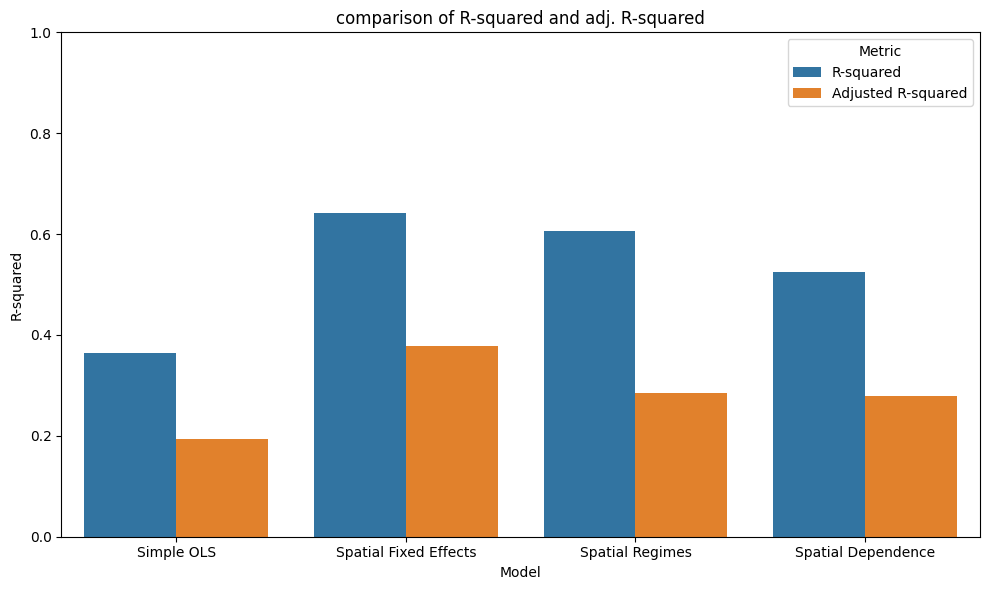

In [2237]:
data = {
    "Model": [
        "Simple OLS", "Simple OLS",
        "Spatial Fixed Effects", "Spatial Fixed Effects",
        "Spatial Regimes", "Spatial Regimes",
        "Spatial Dependence", "Spatial Dependence"
    ],
    "Metric": [
        "R-squared", "Adjusted R-squared",
        "R-squared", "Adjusted R-squared",
        "R-squared", "Adjusted R-squared",
        "R-squared", "Adjusted R-squared"
    ],
    "Value": [
        0.3635, 0.1937,
        0.641, 0.379,
        0.6053, 0.2857,
        0.5258, 0.2792
    ]
}

df = pd.DataFrame(data)

plt.figure(figsize=(10, 6))
sns.barplot(data=df, x="Model", y="Value", hue="Metric")
plt.title("comparison of R-squared and adj. R-squared")
plt.ylabel("R-squared")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()


## Remove overlapping nodes (same location)

In [ ]:
# gdf_unique = df.drop_duplicates(subset="geometry", keep="first").reset_index(drop=True)

# df = gdf_unique.to_crs(epsg=3857)
# len(df)